In [1]:

# quick comparison: Prophet (with Quantity_MT), ARIMA, XGBoost


import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,4)

# helper function
def safe_eval(y_true, y_pred, label="model"):
    try:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        print(f"{label:<12} -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")
        return mae, rmse
    except Exception as e:
        print(f"{label} evaluation failed:", e)
        return None, None


In [2]:
# expects that 02_feature_engineering saved this file
FEAT_PATH = "../data/features_tmt.csv"

df = pd.read_csv(FEAT_PATH, parse_dates=["Invoice_Date"]).sort_values("Invoice_Date")
print("rows:", len(df))
display(df.head(3))

# simple time split: last ~3 months = test
split_date = df["Invoice_Date"].max() - pd.DateOffset(months=3)
train = df[df["Invoice_Date"] <= split_date].copy()
test  = df[df["Invoice_Date"] >  split_date].copy()

print("train:", len(train), " | test:", len(test))
if len(test) == 0:
    print("⚠ test set is empty — widen the window or check your data slice.")


rows: 783


,Invoice_Date,Material_Name,Quantity_MT,Total_Invoice_Value,Unit_Price,UOM,Vendor_Name,year,month,day,...,is_month_start,is_month_end,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,vendor_id,order_qty,log_order_qty
0,2022-05-19,TMT REBAR FE500D DIA 12MM,8.98,659625.9,61750.0,MTS,MS AGARWAL FOUNDRIES PRIVATE LIMITED,2022,5,19,...,0,0,NaN,NaN,NaN,NaN,NaN,7,8.98,2.300583
1,2022-05-19,TMT REBAR FE500D DIA 20MM,19.94,1464692.7,61750.0,MTS,MS AGARWAL FOUNDRIES PRIVATE LIMITED,2022,5,19,...,0,0,61750.0,NaN,NaN,NaN,NaN,7,19.94,3.041661
2,2022-05-21,TMT REBAR FE500D DIA 10MM,7.98,567338.1,60250.0,MTS,Rawmart Material Solutions Pvt Ltd,2022,5,21,...,0,0,61750.0,NaN,NaN,NaN,NaN,12,7.98,2.195000


train: 585  | test: 198


In [3]:
# Prophet is for trend/seasonality; I keep it simple and only add Quantity_MT as a numeric regressor.
try:
    # training frame for prophet
    tmp = train[["Invoice_Date", "Unit_Price", "Quantity_MT"]].copy()
    tmp = tmp.dropna(subset=["Invoice_Date", "Unit_Price"])  # qty can be NaN; we’ll fill later for test
    tmp["ds"] = tmp["Invoice_Date"].dt.floor("D")
    tmp["y"]  = tmp["Unit_Price"]

    m_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
    m_prophet.add_regressor("Quantity_MT")

    # Prophet fit wants only the columns it needs
    m_prophet.fit(tmp[["ds", "y", "Quantity_MT"]])

    if test.empty:
        print("⚠ Prophet skipped: test set empty.")
        p_mae = p_rmse = None
    else:
        test_ = test.copy()
        test_["Invoice_Date"] = test_["Invoice_Date"].dt.floor("D")
        # minimal impute for qty (don’t overthink)
        qty_median = tmp["Quantity_MT"].median()
        test_["Quantity_MT"] = pd.to_numeric(test_["Quantity_MT"], errors="coerce").fillna(qty_median)

        # force prophet to predict exactly our test dates + qty
        future = test_[["Invoice_Date", "Quantity_MT"]].rename(columns={"Invoice_Date": "ds"})
        fc = m_prophet.predict(future)[["ds", "yhat"]]

        joined = fc.set_index("ds").join(test.set_index("Invoice_Date"))[["Unit_Price", "yhat"]].dropna()
        p_mae, p_rmse = safe_eval(joined["Unit_Price"], joined["yhat"], "Prophet+Qty")

        # keep for plot
        prophet_pred = joined["yhat"].values
        prophet_dates = joined.index.to_numpy()
except Exception as e:
    print("Prophet failed:", e)
    p_mae = p_rmse = None
    prophet_pred = None
    prophet_dates = None


02:04:46 - cmdstanpy - INFO - Chain [1] start processing
02:04:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet+Qty  -> MAE: 2519.95 | RMSE: 3555.99


In [4]:
try:
    y_train = train.set_index("Invoice_Date")["Unit_Price"]
    y_test  = test.set_index("Invoice_Date")["Unit_Price"]

    # not over-tuned; just a decent baseline
    arima = ARIMA(y_train, order=(5,1,0)).fit()
    a_pred = arima.forecast(steps=len(y_test))

    a_mae, a_rmse = safe_eval(y_test, a_pred, "ARIMA")
except Exception as e:
    print("ARIMA failed:", e)
    a_mae = a_rmse = None


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA        -> MAE: 5023.94 | RMSE: 6722.27


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [5]:
#  XGBoost (numeric-only features)
try:
    # use only numeric/bool features; the engineered ones cover vendor & qty already
    numeric_cols = train.select_dtypes(include=["number", "bool"]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c != "Unit_Price"]

    if len(feature_cols) == 0:
        raise ValueError("No numeric features found for XGBoost.")

    X_train, y_train_xgb = train[feature_cols].fillna(0), train["Unit_Price"]
    X_test,  y_test_xgb  = test[feature_cols].fillna(0),  test["Unit_Price"]

    model_xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model_xgb.fit(X_train, y_train_xgb)
    x_pred = model_xgb.predict(X_test)

    x_mae, x_rmse = safe_eval(y_test_xgb, x_pred, "XGBoost")
except Exception as e:
    print("XGBoost failed:", e)
    non_numeric = [f"{c}:{train[c].dtype}" for c in train.columns
                   if train[c].dtype not in ("int64","float64","bool","int32","float32")]
    print("Non-numeric columns present:", non_numeric)
    x_pred = None



XGBoost      -> MAE: 2045.89 | RMSE: 2966.34


In [6]:
print("\n=== Scoreboard (lower is better) ===")
print(f"Prophet+Qty : MAE={p_mae if p_mae is not None else 'NA'} | RMSE={p_rmse if p_rmse is not None else 'NA'}")
print(f"ARIMA       : MAE={a_mae if 'a_mae' in globals() else 'NA'} | RMSE={a_rmse if 'a_rmse' in globals() else 'NA'}")
print(f"XGBoost     : MAE={x_mae if 'x_mae' in globals() else 'NA'} | RMSE={x_rmse if 'x_rmse' in globals() else 'NA'}")



=== Scoreboard (lower is better) ===
Prophet+Qty : MAE=2519.9497766556888 | RMSE=3555.9857994803615
ARIMA       : MAE=5023.936440253795 | RMSE=6722.270635408374
XGBoost     : MAE=2045.8887939219653 | RMSE=2966.336407756295


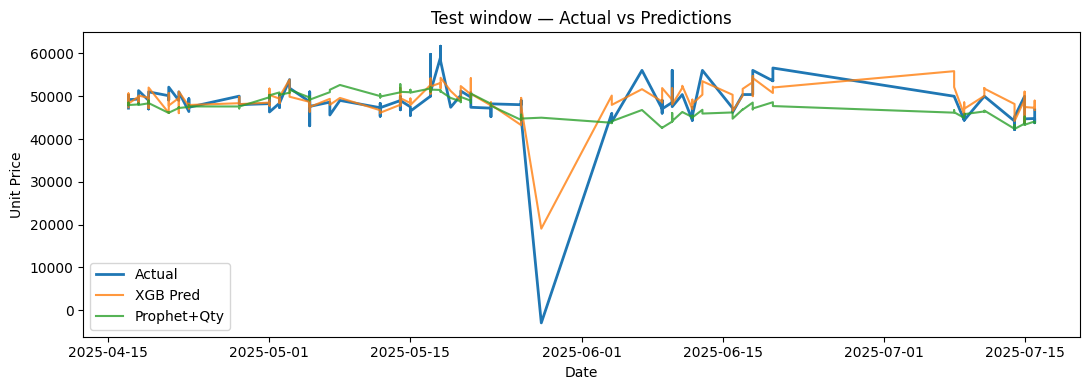

In [7]:

try:
    fig, ax = plt.subplots()
    ax.plot(test["Invoice_Date"], test["Unit_Price"], label="Actual", linewidth=2)

    if x_pred is not None:
        ax.plot(test["Invoice_Date"], x_pred, label="XGB Pred", alpha=0.8)

    if prophet_pred is not None and prophet_dates is not None:
        ax.plot(prophet_dates, prophet_pred, label="Prophet+Qty", alpha=0.8)

    ax.set_title("Test window — Actual vs Predictions")
    ax.set_xlabel("Date"); ax.set_ylabel("Unit Price")
    ax.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("plot skipped:", e)
